In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.interpolate as sci

from gala.units import galactic

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

from empaf.label_model import VerticalLabelModel
from empaf.plot import plot_data_models_label_residual

In [2]:
tbl = at.QTable()
tbl['z'] = np.load('../test/ztest.npy') * u.kpc
tbl['vz'] = np.load('../test/vztest.npy') * u.kpc / u.Gyr
tbl['label'] = np.load('../test/mgtest.npy')

In [3]:
init_model = VerticalLabelModel(
    label_knots=jnp.linspace(0, np.sqrt(1.5), 9)**2,
    e_knots={
        2: jnp.array([0., 1.]),
        4: jnp.array([0., 1.]),
        # 6: jnp.array([0., 1.]),
    },
    unit_sys=galactic
)

In [22]:
im_bins = {
    'z': np.linspace(-2., 2., 91),
    'vz': np.linspace(-0.075, 0.075, 91)
}
data_H = init_model.get_data_im(tbl['z'], tbl['vz'], tbl['label'], im_bins)

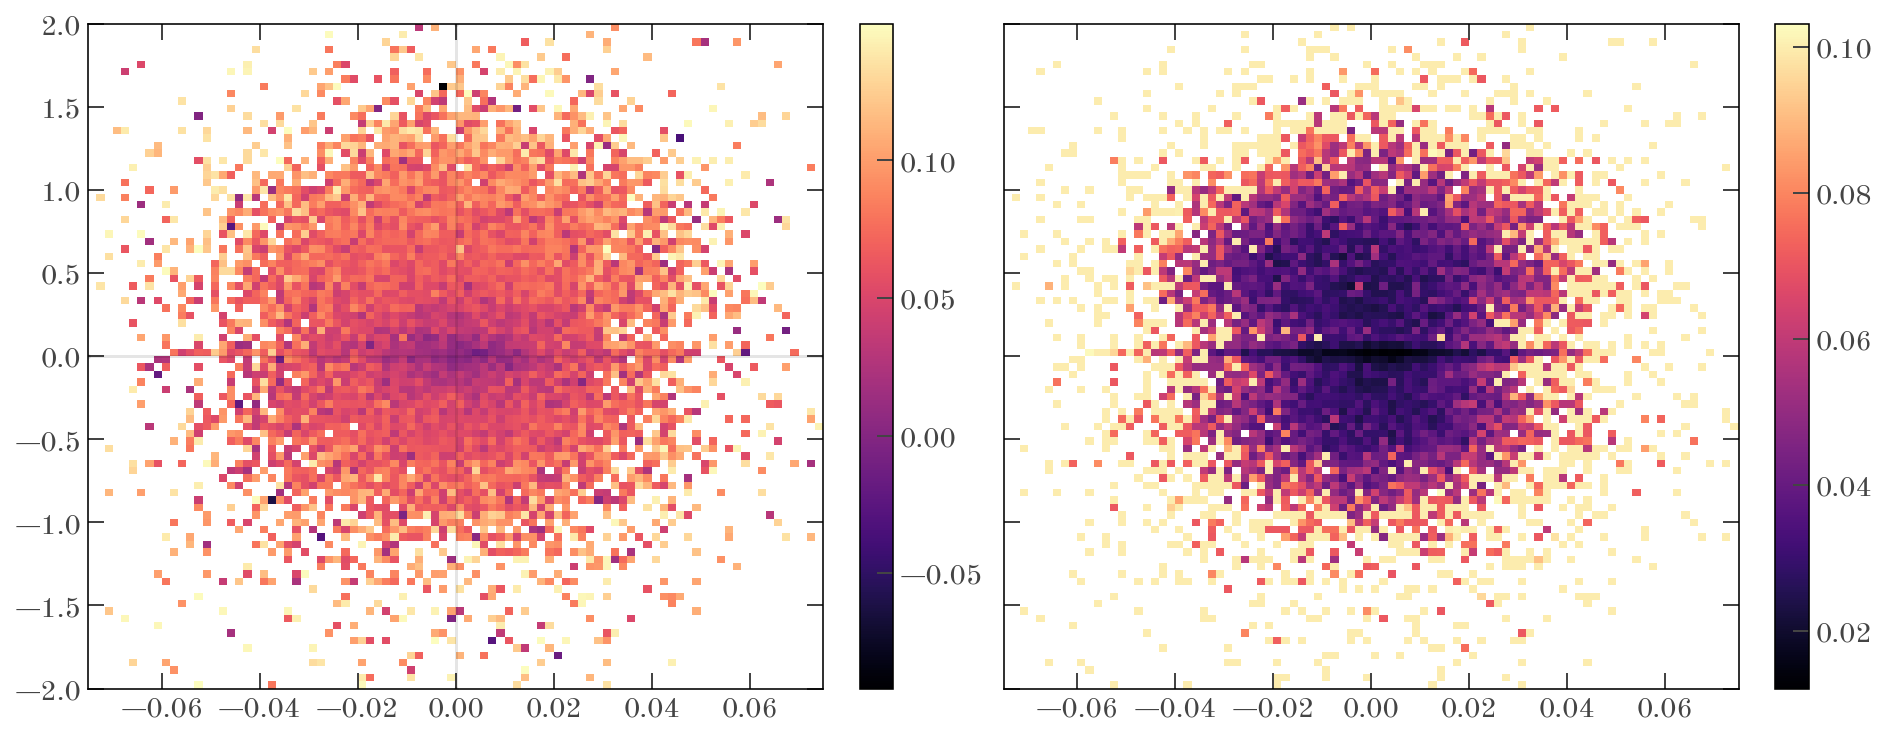

In [23]:
fig, axes = plt.subplots(
    1, 2, figsize=(13, 5), sharex=True, sharey=True, constrained_layout=True
)
cs = axes[0].pcolormesh(data_H["vz"], data_H["z"], data_H["label_stat"])
axes[0].axvline(0., alpha=0.1)
axes[0].axhline(0., alpha=0.1)
fig.colorbar(cs, ax=axes[0])

cs = axes[1].pcolormesh(data_H["vz"], data_H["z"], data_H["label_stat_err"])
fig.colorbar(cs, ax=axes[1])

In [24]:
model0 = init_model.get_params_init(data_H['z'], data_H['vz'], data_H['label_stat'])
model = model0.copy()

In [25]:
bounds_l = {
    "vz0": -0.1,
    "z0": -0.5,
    "label_vals": np.full_like(model0.state["label_vals"], -5.0),
    "ln_Omega": -5.0,
    "e_vals": {},
}

bounds_r = {
    "vz0": 0.1,
    "z0": 0.5,
    "label_vals": np.full_like(model0.state["label_vals"], 5.0),
    "ln_Omega": 0.0,
    "e_vals": {},
}

for m in model0.e_knots:
    bounds_l["e_vals"][m] = np.full_like(model0.state["e_vals"][m], -0.3)
    bounds_r["e_vals"][m] = np.full_like(model0.state["e_vals"][m], 0.3)

In [26]:
clean_mask = np.isfinite(data_H["label_stat"]) & (data_H["label_stat_err"] > 0)
clean_data = {k: v[clean_mask] for k, v in data_H.items()}

In [27]:
res = model.optimize(
    **clean_data, 
    bounds=(bounds_l, bounds_r), 
    jaxopt_kwargs=dict(options=dict(maxls=1000, disp=False))
)
res.state

ScipyMinimizeInfo(fun_val=Array(0.06383278, dtype=float64, weak_type=True), success=True, status=0, iter_num=211)

In [28]:
res.params

{'e_vals': {2: Array([-0.29481329,  0.3       ], dtype=float64),
  4: Array([-0.13842162,  0.15127364], dtype=float64)},
 'label_vals': Array([-0.00740006,  0.01699066,  0.05384385,  0.0773447 ,  0.10447501,
         0.1106693 ,  0.13890569,  0.26044678,  0.31546341], dtype=float64),
 'ln_Omega': Array(-3.22592322, dtype=float64),
 'vz0': Array(0.0012187, dtype=float64),
 'z0': Array(0.00265205, dtype=float64)}

In [29]:
model.label(0., 0.)

Array(-0.00311424, dtype=float64)

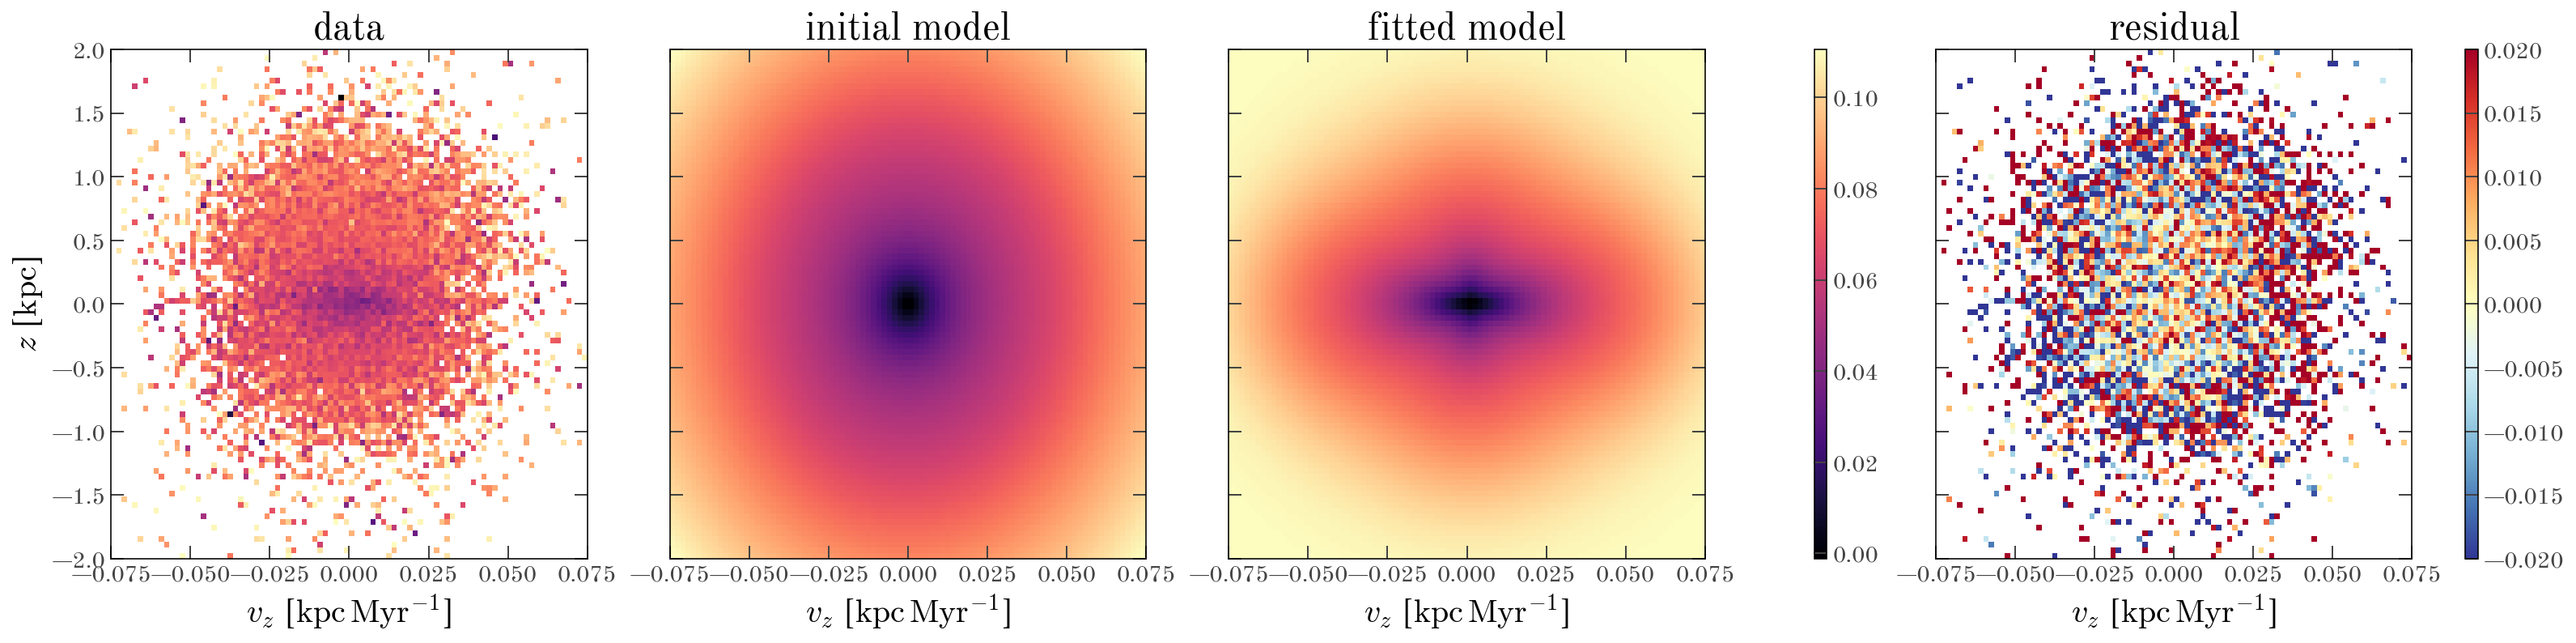

In [35]:
plot_data_models_label_residual(data_H, model0, model);